In [1]:
# imports
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from esem import gp_model
from eofs.xarray import Eof
from utils import *
import gpflow

2024-11-22 05:56:39.406626: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-22 05:56:39.436588: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732280199.474419   12989 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732280199.484498   12989 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-22 05:56:39.521904: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# list of experiment data used for training

train_files= ['ssp126', 'ssp370', 'ssp585', 'historical', 'hist-GHG', 'hist-aer']

### prepare data

In [3]:
# get data
Xtrain, eof_solvers = get_Xtrain(train_files)
Ytrain_tas = get_Ytrain(train_files)['tas'].values.reshape(-1, 96*144)

Xtest = get_Xtest('ssp245', eof_solvers)
Ytest = xr.open_dataset('../test/outputs_ssp245.nc').compute()
tas_truth = Ytest['tas'].mean('member')

In [4]:
# drop rows including nans
train_nan_mask = Xtrain.isna().any(axis=1).values
Xtrain = Xtrain.dropna(axis=0, how='any')
Ytrain_tas = Ytrain_tas[~train_nan_mask]
assert Xtrain.shape[0]==Ytrain_tas.shape[0]

test_nan_mask = Xtest.isna().any(axis=1).values
Xtest = Xtest.dropna(axis=0, how='any')
tas_truth = tas_truth[~test_nan_mask]

In [5]:
# Standardize predictor fields requiring standardization (non-EOFs)
train_CO2_mean, train_CO2_std = Xtrain['CO2'].mean(), Xtrain['CO2'].std()
train_CH4_mean, train_CH4_std = Xtrain['CH4'].mean(), Xtrain['CH4'].std()

Xtrain['CO2'] = (Xtrain['CO2'] - train_CO2_mean) / train_CO2_std
Xtrain['CH4'] = (Xtrain['CH4'] - train_CH4_mean) / train_CH4_std

Xtest['CO2'] = (Xtest['CO2'] - train_CO2_mean) / train_CO2_std
Xtest['CH4'] = (Xtest['CH4'] - train_CH4_mean) / train_CH4_std

In [6]:
# Standardize predictand fields
train_tas_mean, train_tas_std = Ytrain_tas.mean(), Ytrain_tas.std()
Ytrain_tas = (Ytrain_tas - train_tas_mean) / train_tas_std

### Model

In [7]:
kernel_CO2 = gpflow.kernels.Matern32(active_dims=[0]) # active_dims specifies which dimension the kernel is applied to
kernel_CH4 = gpflow.kernels.Matern32(active_dims=[1])

kernel_BC = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[2, 3, 4, 5, 6])
kernel_SO2 = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[7, 8, 9, 10, 11])

kernel = kernel_CO2 + kernel_CH4 + kernel_BC + kernel_SO2

2024-11-22 05:56:50.740753: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [8]:
np.random.seed(5)

"""
In Gaussian Processes, a mean function represents the "prior mean" or the expected value
of the function at any input point before observing any data.
"""
mean = gpflow.mean_functions.Constant()

model = gpflow.models.GPR(data=(Xtrain.astype(np.float64), # cast to float64 because gpflow requires numerical stability
                                Ytrain_tas.astype(np.float64)),
                          kernel = kernel,
                          mean_function = mean)

In [9]:
# define optimizer
optimizer = gpflow.optimizers.Scipy()

# train
optimizer.minimize(model.training_loss,
                   variables=model.trainable_variables,
                   options=dict(disp=True, maxiter=1000))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.13217D+07    |proj g|=  2.67230D+06


 This problem is unconstrained.



At iterate    1    f=  4.82303D+06    |proj g|=  1.26698D+06

At iterate    2    f=  4.48292D+06    |proj g|=  2.01988D+05

At iterate    3    f=  4.43305D+06    |proj g|=  1.95157D+05

At iterate    4    f=  3.96845D+06    |proj g|=  8.74004D+05

At iterate    5    f=  3.66381D+06    |proj g|=  5.16420D+05

At iterate    6    f=  3.56577D+06    |proj g|=  3.42930D+04

At iterate    7    f=  3.55850D+06    |proj g|=  4.04827D+04

At iterate    8    f=  3.55670D+06    |proj g|=  2.25590D+04

At iterate    9    f=  3.55307D+06    |proj g|=  2.53873D+04

At iterate   10    f=  3.54807D+06    |proj g|=  7.91032D+04

At iterate   11    f=  3.54114D+06    |proj g|=  1.08116D+05

At iterate   12    f=  3.53402D+06    |proj g|=  7.39213D+04

At iterate   13    f=  3.53133D+06    |proj g|=  1.06670D+04

At iterate   14    f=  3.53081D+06    |proj g|=  1.03119D+04

At iterate   15    f=  3.53043D+06    |proj g|=  2.44562D+04

At iterate   16    f=  3.52925D+06    |proj g|=  4.77052D+04

At iter

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 3319094.8833318558
        x: [ 9.760e+00  9.214e+00 ... -2.529e+00  5.239e-01]
      nit: 925
      jac: [-4.675e+00  1.071e+01 ... -2.464e+01  1.849e+01]
     nfev: 1059
     njev: 1059
 hess_inv: <18x18 LbfgsInvHessProduct with dtype=float64>

### make prediction

In [10]:
# predict
standard_posterior_mean, standard_posterior_var = model.predict_y(Xtest.values) # predicted mean of GP, predicted variance of GP
posterior_mean = standard_posterior_mean * train_tas_std + train_tas_mean # transform mean prediction to original scale
posterior_stddev = np.sqrt(standard_posterior_var) * train_tas_std # transform variance prediction to original scale standard deviation

In [11]:
# put output back into xarray format for calculating RMSE/plotting
posterior_tas = np.reshape(posterior_mean, [86, 96, 144])
posterior_tas_stddev = np.reshape(posterior_stddev, [86, 96, 144])

posterior_tas_data = xr.DataArray(posterior_tas, dims=tas_truth.dims, coords=tas_truth.coords)
posterior_tas_std_data = xr.DataArray(posterior_tas_stddev, dims=tas_truth.dims, coords=tas_truth.coords)

In [12]:
# Compute RMSEs
print(f"RMSE at 2050: {get_rmse(tas_truth[35], posterior_tas_data[35])}")
print(f"RMSE at 2100: {get_rmse(tas_truth[85], posterior_tas_data[85])}")
print(f"RMSE 2045-2055: {get_rmse(tas_truth[30:41], posterior_tas_data[30:41]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(tas_truth[75:], posterior_tas_data[75:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(tas_truth[35:], posterior_tas_data[35:]).mean()}")

# RMSE for average field over last 20 years
print(f"RMSE average last 20y: {get_rmse(tas_truth[-20:].mean(dim='time'), posterior_tas_data[-20:].mean(dim='time'))}")

RMSE at 2050: 0.3026616879034685
RMSE at 2100: 0.349660122056607
RMSE 2045-2055: 0.37197303087860867
RMSE 2090-2100: 0.36988188858895676
RMSE 2050-2100: 0.3765012617102069
RMSE average last 20y: 0.19389283978715924


[Text(0.5, 1.0, 'Difference')]

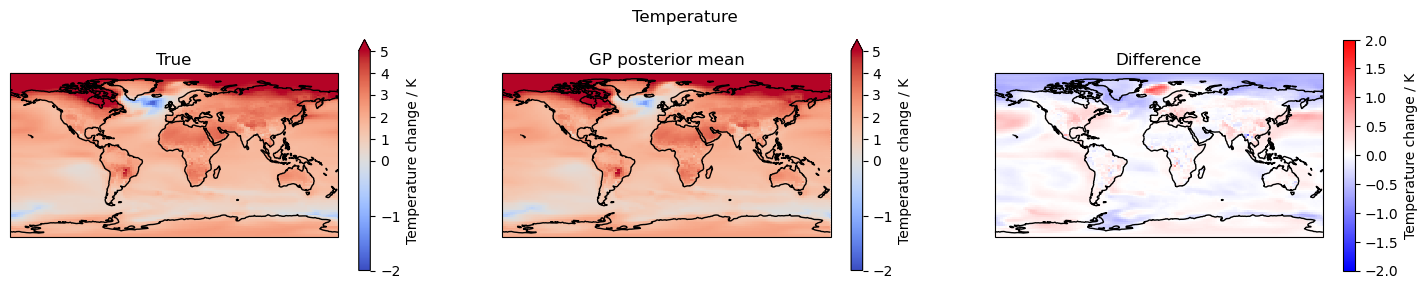

In [18]:
from matplotlib import colors
# plotting predictions
divnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=5)
diffnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=2)

## Temperature
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('Temperature')

# Test
plt.subplot(131, projection=proj)
tas_truth.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                              cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
posterior_tas_data.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                       cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='GP posterior mean')

# Difference
difference = tas_truth - posterior_tas_data
plt.subplot(133, projection=proj)
difference.sel(time=slice(2050,None)).mean('time').plot(cmap="bwr", norm=diffnorm,
                cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')

In [14]:
model

name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.c,Parameter,Identity,,True,"(1,)",float64,[0.52391237]
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,9.2137
GPR.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,9.76014
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.0849203733848593
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,0.7701057103859545
GPR.kernel.kernels[2].variance,Parameter,Softplus,,True,(),float64,0.05500694522190085
GPR.kernel.kernels[2].lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[2.91624279e-02, 5.70395500e+01, 6.89007300e+01..."
GPR.kernel.kernels[3].variance,Parameter,Softplus,,True,(),float64,1.08074
GPR.kernel.kernels[3].lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[14.39288, 15.15776, 28.04018..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.07668340655647475
